In [44]:
import time
from contextlib import contextmanager
from typing import Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
)

import torch
from torch import Tensor


from tqdm import tqdm  # Add tqdm for progress bar
from itertools import product

# RelBench
from relbench.datasets import get_dataset
from relbench.tasks import get_task

import relbench.metrics
import inspect
from skrub import TableVectorizer

# TabPFN
from tabpfn import TabPFNClassifier, TabPFNRegressor

from relbench.modeling.utils import get_stype_proposal
from relbench.modeling.graph import make_pkey_fkey_graph, get_node_train_table_input
from torch_geometric.loader import NeighborLoader
from torch_frame.config.text_embedder import TextEmbedderConfig
from sentence_transformers import SentenceTransformer

# --- ADD: Import Model, test, BCEWithLogitsLoss, L1Loss from train_model.ipynb ---t
from torch.nn import BCEWithLogitsLoss, L1Loss
# --- END ADD ---

from typing import List, Optional


# Device preference
#if torch.backends.mps.is_available():
#    DEVICE = "mps"
#elif torch.cuda.is_available():
#    DEVICE = "cuda"
#else:
#    DEVICE = "cpu"

DEVICE = "cpu"

print(f"Using device: {DEVICE}")

# Define global dataset variable
DATASET = "rel-f1"


Using device: cpu


In [45]:
# Patch relbench.metrics.skm.mean_squared_error to local mean_squared_error
relbench.metrics.skm.mean_squared_error = mean_squared_error

def patched_rmse(true, pred):
    if "squared" in inspect.signature(mean_squared_error).parameters:
        return mean_squared_error(true, pred, squared=False)
    else:
        return np.sqrt(mean_squared_error(true, pred))

relbench.metrics.rmse = patched_rmse

In [46]:
class GloveTextEmbedding:
    def __init__(self, device: Optional[torch.device] = None):
        self.model = SentenceTransformer(
            "sentence-transformers/average_word_embeddings_glove.6B.300d",
            device=device,
        )

    def __call__(self, sentences: List[str]) -> Tensor:
        return torch.from_numpy(self.model.encode(sentences))

In [47]:
@contextmanager
def elapsed_timer():
    start = time.perf_counter()
    yield lambda: time.perf_counter() - start

def classification_metrics(y_true, y_pred, y_prob=None) -> Dict[str, float]:
    out = {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
    }
    if y_prob is not None:
        try:
            out["roc_auc"] = roc_auc_score(y_true, y_prob)
        except Exception:
            out["roc_auc"] = np.nan
    else:
        out["roc_auc"] = np.nan
    return out

def regression_metrics(y_true, y_pred, y_prob=None) -> Dict[str, float]:
    # Accepts y_prob for compatibility, but ignores it
    return {
        "mae": mean_absolute_error(y_true, y_pred),
        "mse": mean_squared_error(y_true, y_pred),
    }

dataset = get_dataset(DATASET)
db = dataset.get_db()

def to_pandas(table):
    if hasattr(table, "to_pandas"):
        return table.to_pandas()
    if hasattr(table, "df"):
        return table.df
    raise ValueError("Unknown table type")

# Convert all tables to pandas DataFrames
tables = {}
for name in db.table_dict:
    tables[name] = to_pandas(db.table_dict[name])

for t in tables.values():
    for col in t.columns:
        if "date" in col.lower():
            t[col] = pd.to_datetime(t[col], errors="coerce")

# --- ADD THIS BLOCK: Build the hetero-temporal graph for GNN experiments ---
col_to_stype_dict = get_stype_proposal(db)
text_embedder_cfg = TextEmbedderConfig(
    text_embedder=GloveTextEmbedding(device=torch.device(DEVICE)), batch_size=256
)
data, col_stats_dict = make_pkey_fkey_graph(
    db,
    col_to_stype_dict=col_to_stype_dict,
    text_embedder_cfg=text_embedder_cfg,
    cache_dir=None,
)

Embedding raw data in mini-batch: 100%|██████████| 4/4 [00:00<00:00, 838.23it/s]
/Users/michaelflppv/PycharmProjects/TabPFN/.venv1/lib/python3.10/site-packages/torch_frame/data/stats.py:177: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ser = pd.to_datetime(ser, format=time_format)
Embedding raw data in mini-batch: 100%|██████████| 4/4 [00:00<00:00, 627.75it/s]
/Users/michaelflppv/PycharmProjects/TabPFN/.venv1/lib/python3.10/site-packages/torch_frame/data/mapper.py:291: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ser = pd.to_datetime(ser, format=self.format, errors='coerce')
Embedding raw data in mini-batch: 100%|██████████| 1/1 [00:00<00:00, 648.57it/s]


In [48]:
# --- NEW CELL: skrub preprocessing helpers ---

def build_tv():
    """
    TableVectorizer turns mixed (numeric + categorical + text + datetime) columns
    into a numeric feature matrix. We keep defaults to match the tutorials’ simplicity.
    """
    return TableVectorizer()

def fit_transform_splits(tv, X_train_df, X_val_df=None, X_test_df=None):
    """
    Fit TV on train only; transform val/test. Cast to float32 for TabPFN.
    """
    # Ensure no NaN or infinite values before vectorizing
    X_train_df = X_train_df.replace([np.inf, -np.inf], np.nan).fillna(0)
    if X_val_df is not None:
        X_val_df = X_val_df.replace([np.inf, -np.inf], np.nan).fillna(0)
    if X_test_df is not None:
        X_test_df = X_test_df.replace([np.inf, -np.inf], np.nan).fillna(0)
    Xt_train = tv.fit_transform(X_train_df).astype(np.float32)
    Xt_val   = tv.transform(X_val_df).astype(np.float32) if X_val_df is not None else None
    Xt_test  = tv.transform(X_test_df).astype(np.float32) if X_test_df is not None else None
    return Xt_train, Xt_val, Xt_test, tv

def _get_df(table):
    # Your tutorial-style accessor: works whether object has `.df` or `.to_pandas()`
    if hasattr(table, "df"):
        return table.df
    if hasattr(table, "to_pandas"):
        return table.to_pandas()
    raise ValueError("Unknown table type for conversion to DataFrame.")


In [49]:
def run_single_table_experiment(task_name: str):
    """
    Apply TabPFN to the single base table provided by the task.
    Uses skrub.TableVectorizer to encode all non-numerical columns.
    """
    global prob_val, prob_test

    # Load task and splits (tutorial API)
    task = get_task(DATASET, task_name)
    train_table = task.get_table("train")
    val_table   = task.get_table("val")
    test_table  = task.get_table("test", mask_input_cols=False)

    # Convert to pandas (tutorial style)
    df_train = _get_df(train_table).copy()
    df_val   = _get_df(val_table).copy()
    df_test  = _get_df(test_table).copy()

    # Optional subsampling to keep parity with your original notebook
    df_train = df_train.sample(n=min(1000, len(df_train)), random_state=42)
    df_val   = df_val.sample(n=min(1000, len(df_val)), random_state=42)

    # Target column name taken from the task object (tutorials use task.target_col)
    target_col = task.target_col

    # Split X/y; keep ALL feature columns (skrub will encode mixed types)
    X_train_df = df_train.drop(columns=[target_col])
    y_train    = df_train[target_col]

    X_val_df = df_val.drop(columns=[target_col])
    y_val    = df_val[target_col]

    X_test_df = df_test.drop(columns=[target_col])
    y_test    = df_test[target_col]

    # Build + fit TableVectorizer on train only; transform val/test
    tv = build_tv()
    Xt_train, Xt_val, Xt_test, tv = fit_transform_splits(tv, X_train_df, X_val_df, X_test_df)

    # Decide model family (simple rule compatible with the tutorials)
    is_regression = pd.api.types.is_float_dtype(y_train) and y_train.nunique() > 10

    if is_regression:
        model = TabPFNRegressor(device=DEVICE)
        metric_fn = regression_metrics
    else:
        model = TabPFNClassifier(device=DEVICE)
        metric_fn = classification_metrics

    # Fit + time it
    with elapsed_timer() as t_fit:
        model.fit(Xt_train, y_train)
    fit_time = t_fit()

    # Predict + time
    with elapsed_timer() as t_pred_val:
        # Generate predictions on the validation set to evaluate model performance before final testing.
        y_val_pred = model.predict(Xt_val)
        prob_val = None
        if not is_regression and hasattr(model, "predict_proba"):
            # Obtain class probabilities for the validation set to support probabilistic metrics such as ROC AUC.
            prob_val = model.predict_proba(Xt_val)
    pred_time_val = t_pred_val()

    with elapsed_timer() as t_pred_test:
        # Generate predictions on the test set to assess the model's generalization capability.
        y_test_pred = model.predict(Xt_test)
        prob_test = None
        if not is_regression and hasattr(model, "predict_proba"):
            # Obtain class probabilities for the test set to support probabilistic evaluation metrics.
            prob_test = model.predict_proba(Xt_test)
    pred_time_test = t_pred_test()

    # Primary metric to mirror RelBench style: accuracy for clf, MAE for reg
    if is_regression:
        primary_metric_val  = mean_absolute_error(y_val,  y_val_pred)
        primary_metric_test = mean_absolute_error(y_test, y_test_pred)
    else:
        primary_metric_val  = accuracy_score(y_val,  y_val_pred)
        primary_metric_test = accuracy_score(y_test, y_test_pred)

    res = {
        "val": {
            **metric_fn(y_val, y_val_pred, prob_val),
            "fit_time": fit_time,
            "predict_time": pred_time_val,
            "primary_metric_relbench": primary_metric_val,
        },
        "test": {
            **metric_fn(y_test, y_test_pred, prob_test),
            "fit_time": fit_time,
            "predict_time": pred_time_test,
            "primary_metric_relbench": primary_metric_test,
        }
    }
    return res


In [50]:
# Create features for drivers based on their past performance
# This function creates features like average position, points, DNF rate, and average laps
def engineer_driver_features():
    # Extract the race dates and results
    results = tables["results"].merge(
        tables["races"][["raceId", "date"]],
        on="raceId", how="left"
    )

    print("results columns after merge:", results.columns.tolist())
    print("Number of rows after merge:", results.shape[0])
    results = results.dropna(subset=["driverId", "date_y"])
    print("Number of rows after dropna:", results.shape[0])

    # Create a did not finish (DNF) flag as indicator for future race outcomes
    results["dnf_flag"] = (~results["positionOrder"].isna()).astype(int)
    # For each driver, calculate the average position, points, DNF rate, and average laps
    # Only the information before the current race is used
    feats = results.groupby("driverId").expanding().agg({
        "positionOrder": "mean",
        "points": "mean",
        "dnf_flag": "mean",
        "laps": "mean"
    }).reset_index()
    feats = feats.rename(columns={
        "positionOrder": "avg_position",
        "points": "avg_points",
        "dnf_flag": "dnf_rate",
        "laps": "avg_laps"
    })
    feats["date"] = results["date_y"].values
    return feats

driver_feats = engineer_driver_features()

results columns after merge: ['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid', 'position', 'positionOrder', 'points', 'laps', 'milliseconds', 'fastestLap', 'rank', 'statusId', 'date_x', 'date_y']
Number of rows after merge: 20323
Number of rows after dropna: 20323


In [51]:
from typing import Any, Dict, List

import torch
from torch import Tensor
from torch.nn import Embedding, ModuleDict
from torch_frame.data.stats import StatType
from torch_geometric.data import HeteroData
from torch_geometric.nn import MLP
from torch_geometric.typing import NodeType

from relbench.modeling.nn import HeteroEncoder, HeteroGraphSAGE, HeteroTemporalEncoder

class Model(torch.nn.Module):

    def __init__(
        self,
        data: HeteroData,
        col_stats_dict: Dict[str, Dict[str, Dict[StatType, Any]]],
        num_layers: int,
        channels: int,
        out_channels: int,
        aggr: str,
        norm: str,
        # List of node types to add shallow embeddings to input
        shallow_list: List[NodeType] = [],
        # ID awareness
        id_awareness: bool = False,
    ):
        super().__init__()

        self.encoder = HeteroEncoder(
            channels=channels,
            node_to_col_names_dict={
                node_type: data[node_type].tf.col_names_dict
                for node_type in data.node_types
            },
            node_to_col_stats=col_stats_dict,
        )
        self.temporal_encoder = HeteroTemporalEncoder(
            node_types=[
                node_type for node_type in data.node_types if "time" in data[node_type]
            ],
            channels=channels,
        )
        self.gnn = HeteroGraphSAGE(
            node_types=data.node_types,
            edge_types=data.edge_types,
            channels=channels,
            aggr=aggr,
            num_layers=num_layers,
        )
        self.head = MLP(
            channels,
            out_channels=out_channels,
            norm=norm,
            num_layers=1,
        )
        self.embedding_dict = ModuleDict(
            {
                node: Embedding(data.num_nodes_dict[node], channels)
                for node in shallow_list
            }
        )

        self.id_awareness_emb = None
        if id_awareness:
            self.id_awareness_emb = torch.nn.Embedding(1, channels)
        self.reset_parameters()

    def reset_parameters(self):
        self.encoder.reset_parameters()
        self.temporal_encoder.reset_parameters()
        self.gnn.reset_parameters()
        self.head.reset_parameters()
        for embedding in self.embedding_dict.values():
            torch.nn.init.normal_(embedding.weight, std=0.1)
        if self.id_awareness_emb is not None:
            self.id_awareness_emb.reset_parameters()

    def forward(
        self,
        batch: HeteroData,
        entity_table: NodeType,
    ) -> Tensor:
        seed_time = batch[entity_table].seed_time
        x_dict = self.encoder(batch.tf_dict)

        rel_time_dict = self.temporal_encoder(
            seed_time, batch.time_dict, batch.batch_dict
        )

        for node_type, rel_time in rel_time_dict.items():
            x_dict[node_type] = x_dict[node_type] + rel_time

        for node_type, embedding in self.embedding_dict.items():
            x_dict[node_type] = x_dict[node_type] + embedding(batch[node_type].n_id)

        x_dict = self.gnn(
            x_dict,
            batch.edge_index_dict,
            batch.num_sampled_nodes_dict,
            batch.num_sampled_edges_dict,
        )

        return self.head(x_dict[entity_table][: seed_time.size(0)])

    def forward_dst_readout(
        self,
        batch: HeteroData,
        entity_table: NodeType,
        dst_table: NodeType,
    ) -> Tensor:
        if self.id_awareness_emb is None:
            raise RuntimeError(
                "id_awareness must be set True to use forward_dst_readout"
            )
        seed_time = batch[entity_table].seed_time
        x_dict = self.encoder(batch.tf_dict)
        # Add ID-awareness to the root node
        x_dict[entity_table][: seed_time.size(0)] += self.id_awareness_emb.weight

        rel_time_dict = self.temporal_encoder(
            seed_time, batch.time_dict, batch.batch_dict
        )

        for node_type, rel_time in rel_time_dict.items():
            x_dict[node_type] = x_dict[node_type] + rel_time

        for node_type, embedding in self.embedding_dict.items():
            x_dict[node_type] = x_dict[node_type] + embedding(batch[node_type].n_id)

        x_dict = self.gnn(
            x_dict,
            batch.edge_index_dict,
        )

        return self.head(x_dict[dst_table])


model = Model(
    data=data,
    col_stats_dict=col_stats_dict,
    num_layers=2,
    channels=128,
    out_channels=1,
    aggr="sum",
    norm="batch_norm",
).to(DEVICE)

In [52]:
# --- MODIFY: make test accept entity_table ---
@torch.no_grad()
def test(loader: NeighborLoader, entity_table: NodeType) -> np.ndarray:
    model.eval()
    pred_list = []
    for batch in loader:
        batch = batch.to(DEVICE)
        pred = model(batch, entity_table)
        pred = pred.view(-1) if pred.dim() > 1 and pred.size(1) == 1 else pred
        pred_list.append(pred.detach().cpu())
    return torch.cat(pred_list, dim=0).numpy()
# --- END MODIFY ---

def run_basic_feature_engineering_experiment(task_name: str):
    """
    Graph‐based experiment: sample temporal subgraphs with NeighborLoader
    so each batch only sees past data (no leakage).
    """
    task = get_task(DATASET, task_name)

    # --- ADD: inject labels into graph data so batch[entity_table].y exists ---
    full_train_tbl = task.get_table("train", mask_input_cols=False)
    y_full = torch.tensor(
        _get_df(full_train_tbl)[task.target_col].values,
        dtype=torch.float
    )
    data[task.entity_table].y = y_full
    # --- END ADD ---

    # build loaders for train/val/test
    loader_dict = {}
    for split, mask in [("train", True), ("val", True), ("test", False)]:
        tbl = task.get_table(split, mask_input_cols=mask)
        # --- LIMIT train/val to 1000 samples ---
        if split in ("train", "val"):
            df_tbl = _get_df(tbl)
            if len(df_tbl) > 1000:
                df_tbl = df_tbl.sample(n=1000, random_state=42)
                # Re-wrap as table object if needed
                tbl = type(tbl)(
                    df_tbl,
                    tbl.fkey_col_to_pkey_table,
                    getattr(tbl, "pkey_col", None),
                    getattr(tbl, "time_col", None),
                )
        tbl_in = get_node_train_table_input(table=tbl, task=task)
        loader_dict[split] = NeighborLoader(
            data,
            num_neighbors=[128, 128],
            time_attr="time",
            input_nodes=tbl_in.nodes,
            input_time=tbl_in.time,
            transform=tbl_in.transform,
            batch_size=512,
            temporal_strategy="uniform",
            shuffle=(split == "train"),
            num_workers=0,
        )

    # import your GNN model and eval fn from train_model.ipynb
    # from train_model import Model, test

    # decide regression vs classification
    sample_tbl = task.get_table("train")
    is_reg = pd.api.types.is_float_dtype(_get_df(sample_tbl)[task.target_col]) and \
             _get_df(sample_tbl)[task.target_col].nunique() > 10

    # instantiate model
    model = Model(
        data=data,
        col_stats_dict=col_stats_dict,
        num_layers=2,
        channels=128,
        out_channels=1,
        aggr="sum",
        norm="batch_norm",
    ).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    loss_fn = BCEWithLogitsLoss() if not is_reg else L1Loss()

    # training
    with elapsed_timer() as t_fit:
        for epoch in range(1, 11):
            model.train()
            for batch in loader_dict["train"]:
                batch = batch.to(DEVICE)
                optimizer.zero_grad()
                out = model(batch, task.entity_table)
                # only take labels for the seed nodes we predicted
                pred   = out.view(-1)
                labels = batch[task.entity_table].y[: pred.size(0)].float()
                loss   = loss_fn(pred, labels)
                loss.backward()
                optimizer.step()
    fit_time = t_fit()

    # validation
    with elapsed_timer() as t_pred_val:
        val_pred = test(loader_dict["val"], task.entity_table)
        val_metrics = task.evaluate(val_pred, task.get_table("val"))
    pred_time_val = t_pred_val()

    # test
    with elapsed_timer() as t_pred_test:
        test_pred = test(loader_dict["test"], task.entity_table)
        test_metrics = task.evaluate(test_pred, task.get_table("test", mask_input_cols=False))
    pred_time_test = t_pred_test()

    return {
        "val": {**val_metrics, "fit_time": fit_time, "predict_time": pred_time_val},
        "test": {**test_metrics, "fit_time": fit_time, "predict_time": pred_time_test},
    }


In [53]:
# TASKS = ["driver-dnf", "driver-top3", "driver-position"]
TASKS = ["driver-dnf"]

all_results_long = []

def results_to_long(task, setting, split, metrics):
    rows = []
    for metric_name, value in metrics.items():
        # Only add row if value is not None and not NaN
        if value is not None and not (isinstance(value, float) and np.isnan(value)):
            rows.append({
                "dataset": DATASET,  # Fill with DATASET variable
                "task": task,
                "split": split,
                "setting": setting,
                "method": "TabPFN_experiment_v1.0",
                "metric": metric_name,
                "score": value
            })
    return rows

# Use tqdm to show progress bar for tasks and settings
for task in tqdm(TASKS, desc="Tasks"):
    task_setting_pairs = list(product(TASKS, [("single", run_single_table_experiment), ("merged", run_basic_feature_engineering_experiment)]))

    for (task, (setting, run_fn)) in tqdm(task_setting_pairs, desc="Task/Setting pairs"):
        res = run_fn(task)
        for split, metrics in res.items():
            all_results_long.extend(results_to_long(task, setting, split, metrics))

results_long_df = pd.DataFrame(all_results_long)
# Ensure 'dataset' is the first column
cols = ["dataset"] + [col for col in results_long_df.columns if col != "dataset"]
results_long_df = results_long_df[cols]
# Round all numerical values in 'score' to 4 decimal places
results_long_df["score"] = results_long_df["score"].apply(lambda x: round(x, 4) if isinstance(x, (float, int, np.floating, np.integer)) else x)

results_long_df.to_csv("results_summary_long.csv", index=False)
results_long_df

Task/Setting pairs:   0%|          | 0/2 [00:00<?, ?it/s]/Users/michaelflppv/PycharmProjects/TabPFN/.venv1/lib/python3.10/site-packages/tabpfn/classifier.py:462: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(

Tasks: 100%|██████████| 1/1 [00:53<00:00, 53.63s/it]


,dataset,task,split,setting,method,metric,score
0,rel-f1,driver-dnf,val,single,TabPFN_experiment_v1.0,accuracy,0.7792
1,rel-f1,driver-dnf,val,single,TabPFN_experiment_v1.0,f1_macro,0.4379
2,rel-f1,driver-dnf,val,single,TabPFN_experiment_v1.0,fit_time,0.0465
3,rel-f1,driver-dnf,val,single,TabPFN_experiment_v1.0,predict_time,18.3948
4,rel-f1,driver-dnf,val,single,TabPFN_experiment_v1.0,primary_metric_relbench,0.7792
5,rel-f1,driver-dnf,test,single,TabPFN_experiment_v1.0,accuracy,0.7051
6,rel-f1,driver-dnf,test,single,TabPFN_experiment_v1.0,f1_macro,0.4135
7,rel-f1,driver-dnf,test,single,TabPFN_experiment_v1.0,fit_time,0.0465
8,rel-f1,driver-dnf,test,single,TabPFN_experiment_v1.0,predict_time,19.8903
9,rel-f1,driver-dnf,test,single,TabPFN_experiment_v1.0,primary_metric_relbench,0.7051


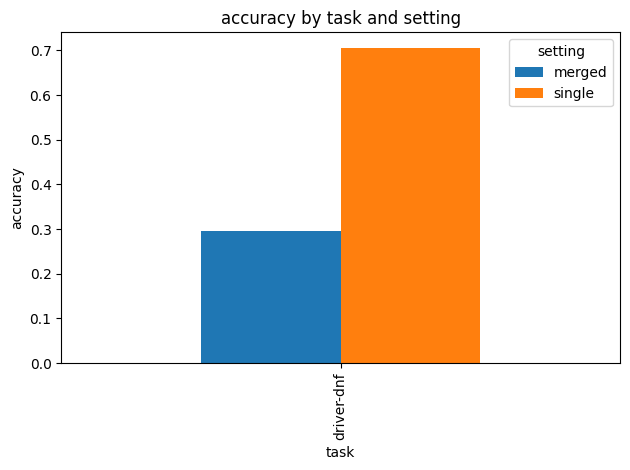

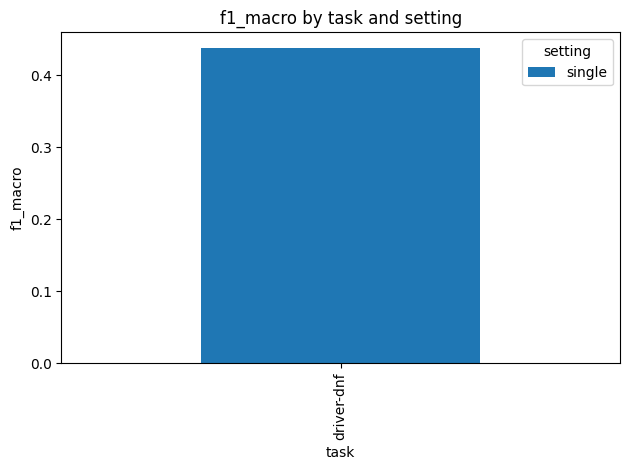

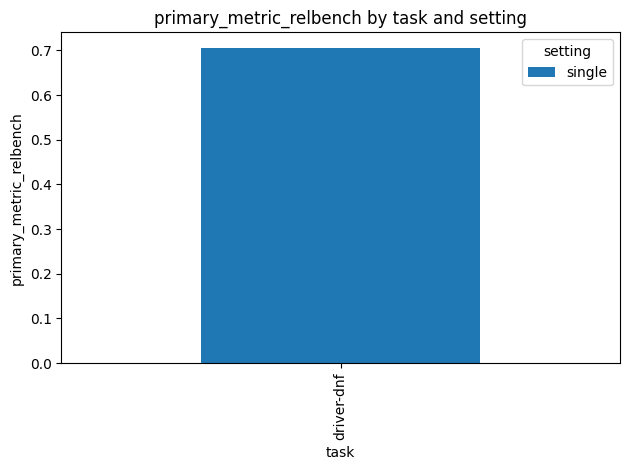

In [54]:
def plot_metric(metric, split=None, setting=None):
    """
    Plot the given metric from results_long_df.
    Optionally filter by split and/or setting.
    """
    df = results_long_df[results_long_df["metric"] == metric]
    if split is not None:
        df = df[df["split"] == split]
    if setting is not None:
        df = df[df["setting"] == setting]
    if df.empty:
        print(f"No data for metric: {metric}, split: {split}, setting: {setting}")
        return
    ax = df.pivot(index="task", columns="setting", values="score").plot(kind="bar")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} by task and setting")
    ax.legend(title="setting")
    plt.tight_layout()
    plt.show()

# Example usage:
plot_metric("accuracy", split="test")
plot_metric("f1_macro", split="val")
plot_metric("primary_metric_relbench", split="test")
